# Sound classification Intro

As part of the sound classification project, this notebook demonstrates the typical ML process such as data exploration, feature engineering, modeling and evaluation.

The sound data is obtained from [this kaggle dataset](https://www.kaggle.com/datasets/mmoreaux/environmental-sound-classification-50). As described in the README, each data row contains a reference to the .wav sound file and the class label for it. 



In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import IPython.display as ipd

In [91]:
%matplotlib inline
%load_ext tensorboard

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Data Loading and preprocessing

To execute this notebook, the data should be downloaded and saved in the same structure as indicated by the following variables:

In [92]:
CSV_FILE_PATH = "data/esc50.csv"  # path of csv file
DATA_PATH = "data/audio/44100/" # path to folder containing audio files

In [93]:
#reading the csv file
df = pd.read_csv(CSV_FILE_PATH)
df

filename  fold  target        category  esc10  src_file take
0      1-100032-A-0.wav     1       0             dog   True    100032    A
1     1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2     1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3     1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4     1-101296-A-19.wav     1      19    thunderstorm  False    101296    A
...                 ...   ...     ...             ...    ...       ...  ...
1995   5-263831-B-6.wav     5       6             hen  False    263831    B
1996  5-263902-A-36.wav     5      36  vacuum_cleaner  False    263902    A
1997   5-51149-A-25.wav     5      25       footsteps  False     51149    A
1998    5-61635-A-8.wav     5       8           sheep  False     61635    A
1999     5-9032-A-0.wav     5       0             dog   True      9032    A

[2000 rows x 7 columns]

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2000 non-null   object
 1   fold      2000 non-null   int64 
 2   target    2000 non-null   int64 
 3   category  2000 non-null   object
 4   esc10     2000 non-null   bool  
 5   src_file  2000 non-null   int64 
 6   take      2000 non-null   object
dtypes: bool(1), int64(3), object(3)
memory usage: 95.8+ KB


For simplification, I choose only 10 classes out of the 40 avaiable in the data set:

In [95]:
class_selection = [
    "thunderstorm",
    "rain",
    "sea_weaves",
    "dog",
    "cat",
    "chirping_birds",    
    "breathing",
    "keyboard_typing",
    "coughing",
    "drinking_sipping",
    "car_horn"
]

df_sel = df[df["category"].isin(class_selection)]
classes = df_sel['category'].unique()
classes

array(['dog', 'chirping_birds', 'thunderstorm', 'keyboard_typing',
       'car_horn', 'drinking_sipping', 'rain', 'breathing', 'coughing',
       'cat'], dtype=object)

In [96]:
# Enumerate the classes
class_dict = {i:x for x,i in enumerate(classes)}
class_dict

{'dog': 0,
 'chirping_birds': 1,
 'thunderstorm': 2,
 'keyboard_typing': 3,
 'car_horn': 4,
 'drinking_sipping': 5,
 'rain': 6,
 'breathing': 7,
 'coughing': 8,
 'cat': 9}

In [97]:
# Map each category to a new target column
df_sel.loc[:, 'target'] = df_sel['category'].map(class_dict)

In [98]:
# Take a sample from the previous selection of classes and save it to data/samples. This will be useful for later trying out the model with a web application
sample_list = df_sel.sample(10)["filename"].to_list()

import shutil
def copy_files(file_list, source_dir, destination_dir):
    for file_name in file_list:
        source_path = source_dir + '/' + file_name
        destination_path = destination_dir + '/' + file_name
        shutil.copy(source_path, destination_path)


source_dir = 'data/audio/44100'
destination_dir = 'data/samples'

# copy_files(sample_list, source_dir, destination_dir)


### Data exploration and feature engineering

For the purpose of showcasing how the audio features are proccesed, only a sample containing 1 instance of each class is required:

In [99]:
# select a sample 
sample_df = df_sel.drop_duplicates(subset=['target'])
sample_df

filename  fold  target          category  esc10  src_file take
0     1-100032-A-0.wav     1       0               dog   True    100032    A
1    1-100038-A-14.wav     1       1    chirping_birds  False    100038    A
4    1-101296-A-19.wav     1       2      thunderstorm  False    101296    A
36      1-137-A-32.wav     1       3   keyboard_typing  False       137    A
53    1-17124-A-43.wav     1       4          car_horn  False     17124    A
61    1-17295-A-29.wav     1       5  drinking_sipping  False     17295    A
62    1-17367-A-10.wav     1       6              rain   True     17367    A
76    1-18631-A-23.wav     1       7         breathing  False     18631    A
84    1-19111-A-24.wav     1       8          coughing  False     19111    A
175    1-34094-A-5.wav     1       9               cat  False     34094    A

In [100]:
# Reproduce some audio samples
print(sample_df.iloc[0]["category"])
ipd.Audio(DATA_PATH + sample_df.iloc[0]["filename"])
print(sample_df.iloc[1]["category"])
ipd.Audio(DATA_PATH + sample_df.iloc[1]["filename"])
print(sample_df.iloc[2]["category"])
ipd.Audio(DATA_PATH + sample_df.iloc[2]["filename"])

dog


chirping_birds


thunderstorm


Next, as part of the data exploratory analysis, the audio signals are loaded and converted into mel spectrograms. They are a representation of an audio signal where the frequency scale is converted to the Mel scale, which approximates the human ear's response more closely than the linearly-spaced frequency bands used in the typical spectrogram. They provided us with an useful feature representation for performing audio classification

In [101]:
signals = {}
mel_spectrograms = {}
mfccs = {}

for i, row in tqdm(sample_df.iterrows()):  # every row will be like [[index], [filename , target , category]]
    signal , rate = librosa.load(DATA_PATH+ row["filename"])
    signals[row["category"]] = signal    # fill signal for each category. eg. signal["dog"] = signal of dog sound
    
    mel_spec = librosa.feature.melspectrogram(y=signal , sr=rate ,  n_fft=2048, hop_length=512)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  #visualizing mel_spectrogram directly gives black image. So, coverting from power_to_db is required
    mel_spectrograms[row["category"]] = mel_spec
    
    mfcc = librosa.feature.mfcc(y=signal , sr=rate , n_mfcc=13, dct_type=3)
    mfccs[row["category"]] = mfcc

10it [00:00, 39.62it/s]


In [102]:
import seaborn as sns

def plot_signal_seaborn(signal):
    """
    this function will take the signal dictionary and plot the signals using seaborn
    """
    sns.set(style='whitegrid')
    fig , axes = plt.subplots(nrows=2 , ncols=5 , sharex =False ,sharey=True,figsize=(20,5))
    fig.suptitle('Time series',size=15)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            sns.lineplot(data=list(signals.values())[i], ax=axes[x,y])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

First visualize the time series corresponding to each of the audio signals in the sample

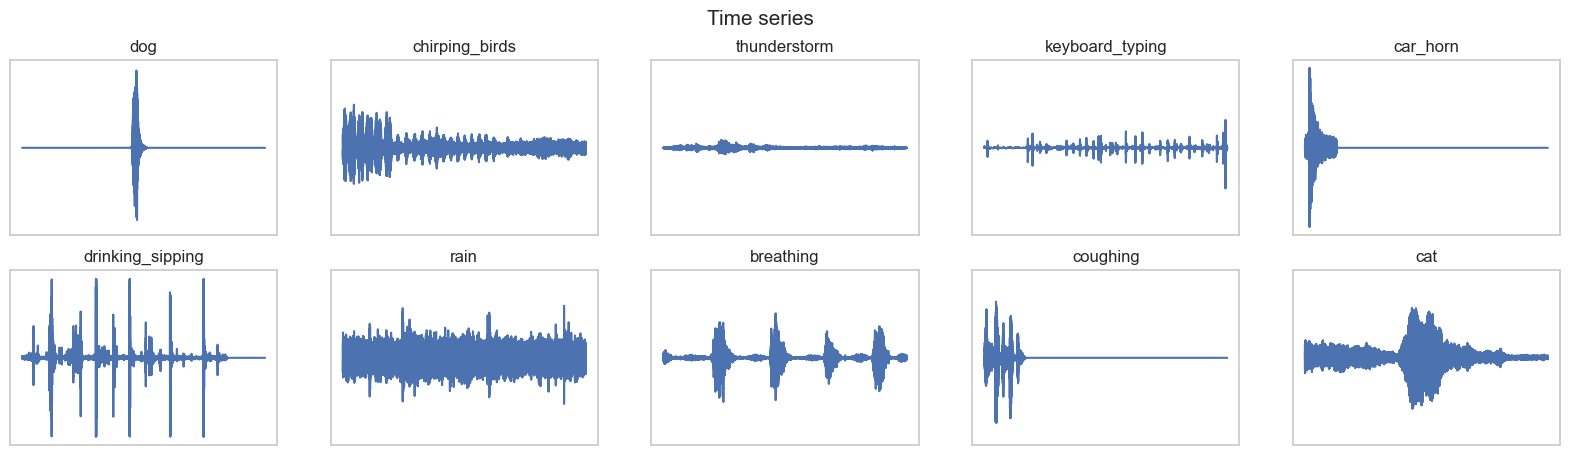

In [103]:
plot_signal_seaborn(signals)

In [104]:
def dis_feature(mfccs, cmap=None):
    """
    this function will take the mfcc/mel_spectrogram dictionary and plot the signals
    """
    fig ,axes= plt.subplots(nrows=2 , ncols=5 , sharex=False, sharey=True , figsize=(40,10))
    fig.suptitle('mel')
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i], cmap=cmap,interpolation='nearest')
            # axes[x,y].get_xaxis().set_visible(False)
            # axes[x,y].get_yaxis().set_visible(False)
            i+=1

Now visualize the mel spectrograms for each signal

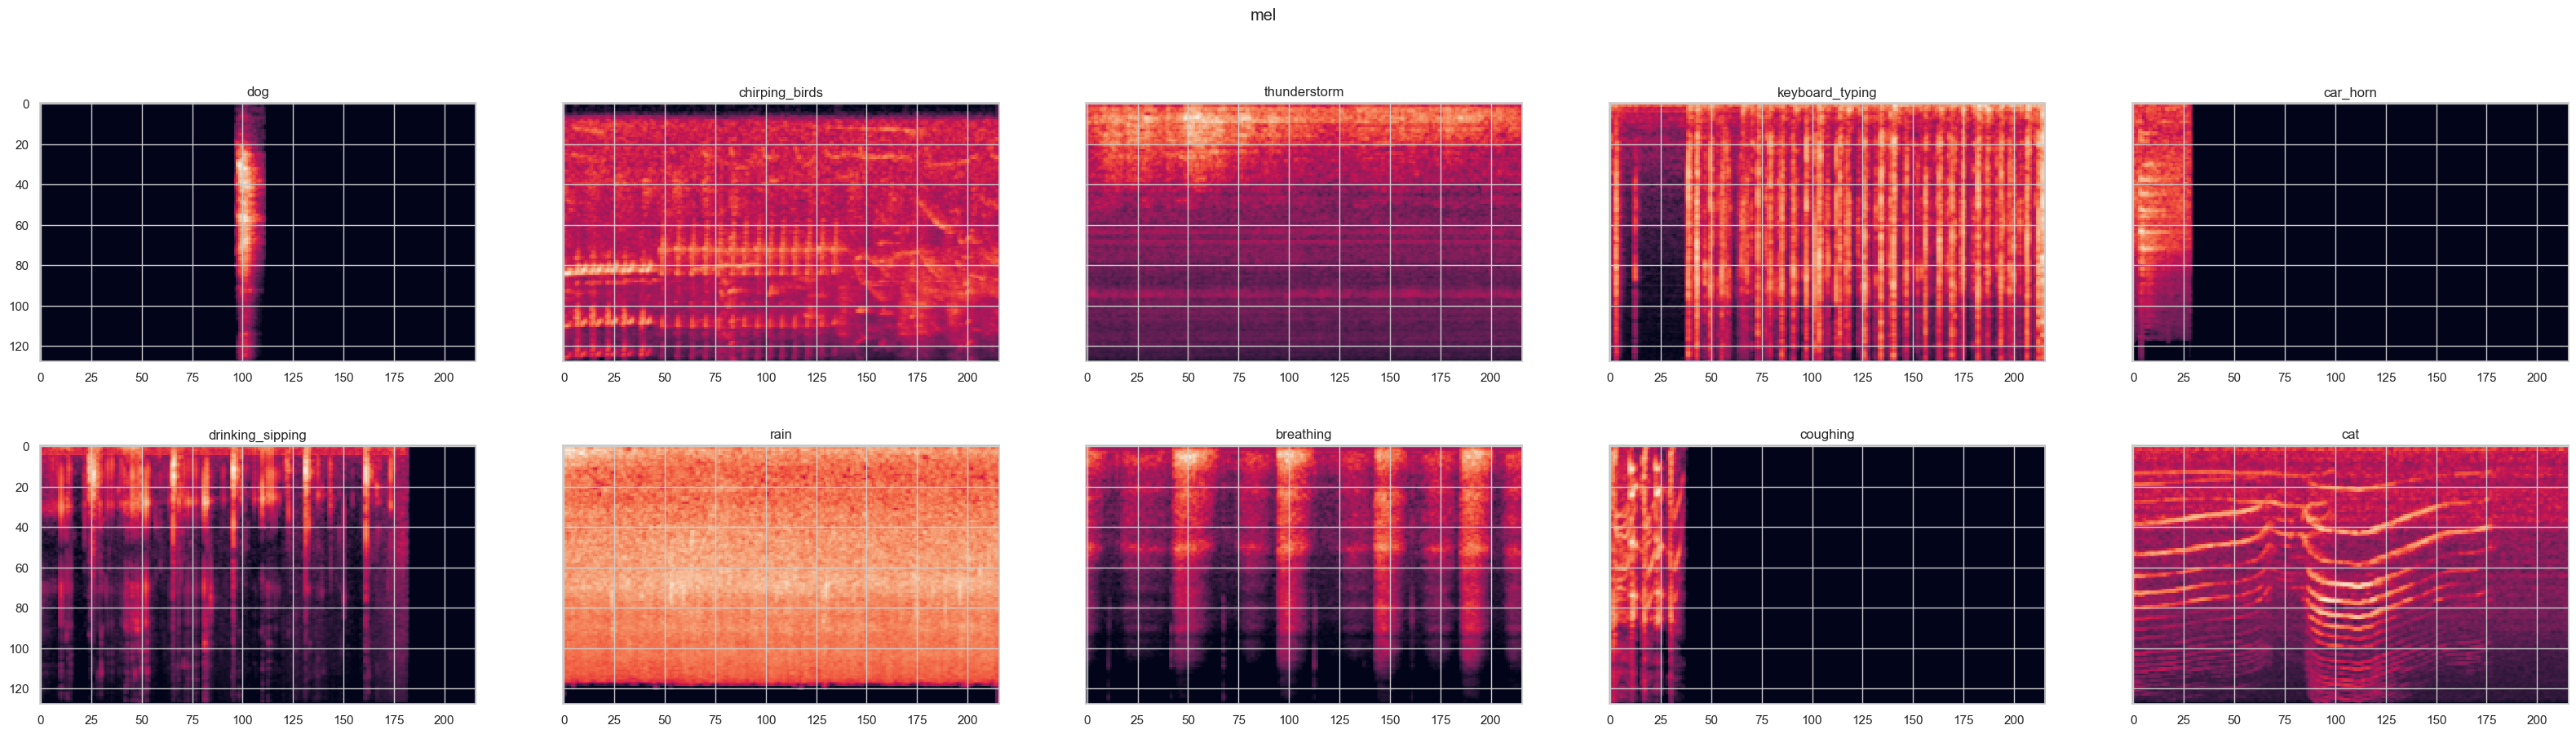

In [105]:
dis_feature(mel_spectrograms)

This spectrogram representation gives as an idea of what an audio signal looks like in the frequency spectrum. This type of generated images can be used as features and classified. However, since we are not dealing with large amounts of data in this project, the MFCC trasnformation is used instead which is a more compact representation of the audio signal and a simplification of the mel spectrogram. For a comprehensive explanation of MFCC check [this link](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).

### Audio data augmentation 

For each of our sound classes we have 40 instances. This might not be enough to have a robust classifier. In order to mitigate this problem, the audio signals are augmented with different tecniques.

In [106]:
df_sel.head()

filename  fold  target        category  esc10  src_file take
0    1-100032-A-0.wav     1       0             dog   True    100032    A
1   1-100038-A-14.wav     1       1  chirping_birds  False    100038    A
4   1-101296-A-19.wav     1       2    thunderstorm  False    101296    A
5   1-101296-B-19.wav     1       2    thunderstorm  False    101296    B
14   1-110389-A-0.wav     1       0             dog   True    110389    A

In [107]:
def add_noise(data, scale=0.05):
    noise = np.random.normal(0, scale, len(data))
    audio_noisy = data + noise
    return audio_noisy
    
def pitch_shifting(data, sr=16000):
    sr  = sr
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'),  sr=sr, n_steps=pitch_change, 
                                          bins_per_octave=bins_per_octave)
    return data

def random_shift(data):
    timeshift_fac = 0.2 *2*(np.random.uniform()-0.5)  # up to 20% of length
    start = int(data.shape[0] * timeshift_fac)
    if (start > 0):
        data = np.pad(data,(start,0),mode='constant')[0:data.shape[0]]
    else:
        data = np.pad(data,(0,-start),mode='constant')[0:data.shape[0]]
    return data

def volume_scaling(data):
    dyn_change = np.random.uniform(low=1.5,high=2.5)
    data = data * dyn_change
    return data
    
def time_stretching(data, rate=1.5):
    input_length = len(data)
    streching = data.copy()
    streching = librosa.effects.time_stretch(streching, rate=rate)
    
    if len(streching) > input_length:
        streching = streching[:input_length]
    else:
        streching = np.pad(streching, (0, max(0, input_length - len(streching))), "constant")
    return streching

In [108]:
import IPython.display as ipd

row = df_sel.iloc[10]

file_name = row["filename"]
print(row["category"])
signal , sr = librosa.load(DATA_PATH+file_name)
print("original")
ipd.Audio(signal, rate=sr)

noised = add_noise(signal, 0.005)
print("noised")
ipd.Audio(noised, rate=sr) 

shifted = pitch_shifting(signal)

print("pitch shifted")
ipd.Audio(shifted, rate=sr)

print("random shifted")
r_shifted = random_shift(signal)
ipd.Audio(r_shifted, rate=sr)

print("volume scaled")
vol_scaled = volume_scaling(signal)
ipd.Audio(vol_scaled, rate=sr)

print("time stretching")
time_stretched = time_stretching(signal)
len(time_stretched)
ipd.Audio(time_stretched, rate=sr)



breathing
original


noised


pitch shifted


random shifted


volume scaled


time stretching


110250

## Modeling

With the data augmentation tecniques and the type of audio representation selected, a classifier model can be trained. 
As we are dealing with image representations of the audio signals (mffcs), the best choice for our model is a convolutional neural network.

The network utilizes batch normalization for improved performance and dropout layers for avoiding overfitting

In [109]:
# Data preparation helper functions

def augment_df(df):
    """
    Apply variouys augmentation strategies the signals provided in the df
    """
    totals = []
    
    for i, row in df.iterrows():
        df_temp = pd.DataFrame()
        signal , sr = librosa.load(DATA_PATH+row["filename"])
        aug_signals = {
            "original": signal,
            "noised": add_noise(signal, 0.005),
            "pitch_shift": pitch_shifting(signal),
            "random_shifted": random_shift(signal),
            "vol_scaled": volume_scaling(signal),
            "time_stretched": time_stretching(signal)
        }

        df_temp = df_temp._append([row]*len(aug_signals),ignore_index=True)

        df_temp["signal"] = aug_signals.values()
        df_temp["type"] = aug_signals.keys()
        
        totals.append(df_temp)
            
    return pd.concat(totals)

def load_signals(df):
    """
    Given a df with references to audio files, load each of the file to a numpy array 
    and returned a new dataframe with the loaded signals
    """
    df["signal"] = df["filename"].apply(lambda x: librosa.load(DATA_PATH+x)[0])
    return df

def df_to_tf(df):
    """
    Given a dataframe with audio signals as numpy arrays, apply the mfcc transformation and categorize the label classes.
    and reshape into X and y for the CNN model. 
    """
    sr = 22050
    X , y = [] , []
    for i, data in tqdm(df.iterrows()):
        mfcc_ = librosa.feature.mfcc(y=data["signal"], sr=sr, n_mfcc=13)
        X.append(mfcc_)
        y.append(data["target"])

    # convert list to numpy array
    X = np.array(X) 
    y = np.array(y)

    #one-hot encoding the target
    y = tf.keras.utils.to_categorical(y , num_classes=10)

    # our tensorflow model takes input as (no_of_sample , height , width , channel).
    # here X has dimension (no_of_sample , height , width).
    # So, the below code will reshape it to (no_of_sample , height , width , 1).
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    return X, y

In [110]:
from keras.layers import Dropout, BatchNormalization

# Define the CNN architecture
def create_model():
    INPUTSHAPE = (13,216,1)
    model = models.Sequential([
                          layers.Conv2D(16 , (3,3),activation = 'relu',padding='valid', input_shape = INPUTSHAPE),
                          BatchNormalization(),
                          layers.Conv2D(64, (3,3), activation='relu',padding='valid'),
                          BatchNormalization(),
                          layers.Conv2D(32, (3,3), activation='relu',padding='valid'),
                          BatchNormalization(),
                          layers.GlobalAveragePooling2D(),
                          Dropout(0.5),
                          layers.Dense(32 , activation = 'relu'),
                          Dropout(0.5),
                          layers.Dense(10 , activation = 'softmax')
    ])
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'acc')
    return model

In [111]:
# Modeling
INPUTSHAPE = (13,216,1)
LOGDIR = "logs"
CPKT = "cpkt/"

#this callback is used to prevent overfitting.
callback_1 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.01, patience=60, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

#this checkpoint saves the best weights of model at every epoch
callback_2 = tf.keras.callbacks.ModelCheckpoint(
    CPKT, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None
)

#this is for tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOGDIR)

### Cross validation

Perform closs validation in order to find the best model hyperparameters.

In [112]:
# Cross validation can take quite some time so only activate it for forcing this step
CROSS_VALIDATION = False

if CROSS_VALIDATION: 
    df_augmented = augment_df(df_sel)

    n_folds = 5
    fold_accuracy = []

    for i in range(1, n_folds + 1):

        # split folds
        df_train_fold = df_augmented[df_augmented["fold"] !=i]

        # Select only the original data for the validation fold
        # since the augmented data should not be used for validation.
        df_val_fold = df_augmented[(df_augmented["fold"] == i) & (df_augmented["type"] == "original")] 

        # convert to tensors
        X_train, y_train =  df_to_tf(df_train_fold)
        X_val, y_val = df_to_tf(df_val_fold)

        model = create_model()
        model.fit(X_train,y_train,
                validation_data=(X_val,y_val),
                epochs=120,
                callbacks = [callback_1 , callback_2 , tensorboard_callback])
        
        _, accuracy = model.evaluate(X_val, y_val, verbose=0)
        fold_accuracy.append(accuracy)

In [113]:
print(f"Average Accuracy: {np.mean(fold_accuracy) * 100}")

Average Accuracy: 82.74999976158142


With the choosen model hyperparameters an accuracy of 82% across folds is achieved. 

### Training and validation

The hyperparameters found during the training phase can now be used for training a model with the full dataset.

In [114]:
df_train, df_val = train_test_split(df_sel, test_size=0.2, random_state=2023)

# augment only the training data
df_train_aug = augment_df(df_train)
df_val = load_signals(df_val)

X_train, y_train = df_to_tf(df_train_aug)
X_val, y_val = df_to_tf(df_val)

X_train.shape
y_train.shape

1920it [00:13, 143.95it/s]
80it [00:00, 148.84it/s]


(1920, 13, 216, 1)

(1920, 10)

In [115]:
model = create_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 11, 214, 16)       160       
                                                                 
 batch_normalization_21 (Bat  (None, 11, 214, 16)      64        
 chNormalization)                                                
                                                                 
 conv2d_22 (Conv2D)          (None, 9, 212, 64)        9280      
                                                                 
 batch_normalization_22 (Bat  (None, 9, 212, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_23 (Conv2D)          (None, 7, 210, 32)        18464     
                                                                 
 batch_normalization_23 (Bat  (None, 7, 210, 32)      

In [116]:
# Depending on your system resources the training phase can be time consuming so set this flag to True only if retraining is required. 
TRAIN_MODEL = False

if TRAIN_MODEL:
        model = create_model()
        model.fit(X_train,y_train,
                validation_data=(X_val,y_val),
                epochs=90,
                callbacks = [callback_1 , callback_2 , tensorboard_callback])

In [117]:
import tensorflow as tf
# Save the model
# model.save("model/model.h5")

## Model evaluation

In [118]:
# Load the model
model = tf.keras.models.load_model("model/model.h5")

In [119]:
inverted_dict = {value: key for key, value in class_dict.items()}

def sample_inference(row):
    xp, yp = df_to_tf(row)
    prediction = model.predict(xp)  # Get the model's prediction

    # # The prediction is an array of probabilities for each class. 
    # # To get the class with the highest probability, you can use argmax
    predicted_class = np.argmax(prediction)

    print(f"The predicted class is {inverted_dict[predicted_class]}")

row = df_val.sample(1)
ipd.Audio(row["signal"].iloc[0], rate=sr)
sample_inference(row)
print("Actual class:", inverted_dict[row["target"].iloc[0]])

1it [00:00, 60.17it/s]

1/1 [==============================] - 0s 111ms/step
The predicted class is coughing
Actual class: coughing



2024-01-14 17:19:15.137655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [129]:
predictions = model.predict(X_val)
y_pred = np.argmax(predictions, axis=1)
y_val_target = np.argmax(y_val, axis=1)

3/3 [==============================] - 0s 31ms/step


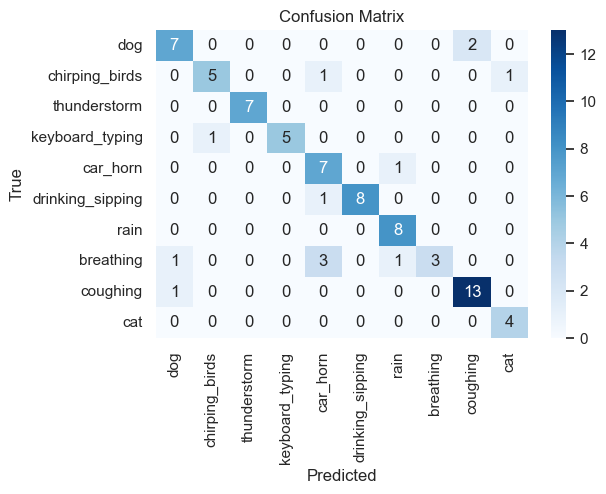

In [136]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val_target, y_pred)

def plot_confusion_matrix(conf_matrix):
    # Create a heatmap
    class_names = class_dict.keys()

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm)

In [139]:
from sklearn.metrics import classification_report
report = classification_report(y_val_target, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.78      0.78         9
           1       0.83      0.71      0.77         7
           2       1.00      1.00      1.00         7
           3       1.00      0.83      0.91         6
           4       0.58      0.88      0.70         8
           5       1.00      0.89      0.94         9
           6       0.80      1.00      0.89         8
           7       1.00      0.38      0.55         8
           8       0.87      0.93      0.90        14
           9       0.80      1.00      0.89         4

    accuracy                           0.84        80
   macro avg       0.87      0.84      0.83        80
weighted avg       0.87      0.84      0.83        80

